# Twitter Sentiment Analysis

Hate Speech in the form of racism and sexism has become a nuisance on twitter and it is important to segregate these sort of tweets from the rest. We provide Twitter data that has both normal and hate tweets. Your task as a Data Scientist is to identify the tweets which are hate tweets and which are not

In [242]:
# Importing Libraries 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import punkt
from wordcloud import WordCloud
from html.parser import HTMLParser
from textblob import TextBlob
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [171]:
# Load dataset train and test
train_tweet = pd.read_csv('/home/admin1/PycharmProjects/Basic Python/myprograms/WEEK_13/Datasets/train_tweets.csv')
test_tweet = pd.read_csv('/home/admin1/PycharmProjects/Basic Python/myprograms/WEEK_13/Datasets/test_tweets.csv') 

In [172]:
print('The train tweets has id label and tweet column')
train_tweet.head()

The train tweets has id label and tweet column


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [173]:
print('The  test tweets has id  and tweet column')
test_tweet.head()

The  test tweets has id  and tweet column


,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [174]:
print('information about train tweets\n')
train_tweet.info()

information about train tweets

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [175]:
print('Information about test tweets\n')
test_tweet.info()

Information about test tweets

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
id       17197 non-null int64
tweet    17197 non-null object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


We can see in above tweet column in both data sets Training & Testing tweets are unstructured, for better analysis we first need to structure the tweets, remove the unwanted words, replace the misspelled words with the correct ones, replace the abriviation with full words

In [176]:
# Merging both the data sets as tweets in both the data set is unstructured
combine_tweets = train_tweet.append(test_tweet, ignore_index= True, sort=False)
combine_tweets.head(10)

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...
7,8,0.0,the next school year is the year for exams.ð...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...


In [177]:
# information of combine tweets
combine_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49159 entries, 0 to 49158
Data columns (total 3 columns):
id       49159 non-null int64
label    31962 non-null float64
tweet    49159 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB


# Data Preprocessing and Cleaning

Convertig HTML entities

In [178]:
print("""Converting html entities i.e. (&lt; &gt; &amp;)
( "&lt;" is converted to “<” and "&amp;" is converted to “&”)""")
# created object of HTMLparser
html_parser =  HTMLParser()
print('\nHTMLParser object has created\n')

Converting html entities i.e. (&lt; &gt; &amp;)
( "&lt;" is converted to “<” and "&amp;" is converted to “&”)

HTMLParser object has created



In [179]:
# created new column i.e. cleaned_tweet contains same tweets but  in cleaned  version
combine_tweets['cleaned_tweet'] =  combine_tweets['tweet'].apply(lambda x: html_parser.unescape(x))
combine_tweets.head(10)

,id,label,tweet,cleaned_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,@user camping tomorrow @user @user @user @use...
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams.ð...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,@user @user welcome here ! i'm it's so #gr...


Removing "@user" from all the tweets

In [180]:
# Removing @user from  all the tweets

# re library used to find all regex pattern "@[\w]*" in text_data
def remove_patterns(tweet_text,pattern):
    r = re.findall(pattern,tweet_text)
    for i in r:
        tweet_text = re.sub(i,'',tweet_text)
    return tweet_text

In [181]:
#  remove twitter handles (@user)
combine_tweets['cleaned_tweet'] = np.vectorize(remove_patterns)(combine_tweets['cleaned_tweet'], "@[\w]*")
combine_tweets.head(10)

,id,label,tweet,cleaned_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ¦
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams.ð...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here ! i'm it's so #gr8 !


change all tweets into lowercase

In [182]:
# change all tweets into lowercase
combine_tweets['cleaned_tweet'] =  combine_tweets['cleaned_tweet'].apply(lambda x: x.lower())
combine_tweets.head()

,id,label,tweet,cleaned_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


Apostrophe Lookup

In [183]:
# Apostrophe Lookup
apostrophe_look = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [184]:
# display tweets without apostrophe
apostrophe_look

{"ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

In [185]:
# lookup dictionary
def lookup_dictionary(text,dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [186]:
combine_tweets['cleaned_tweet'] = combine_tweets['cleaned_tweet'].apply(lambda  x: lookup_dictionary(x,apostrophe_look))
combine_tweets.head()

,id,label,tweet,cleaned_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i cannot use cause t...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


Short Word Lookup

In [187]:
# short word lookup
short_word = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [188]:
# combine short words into cleaned tweet
combine_tweets['cleaned_tweet']=combine_tweets['cleaned_tweet'].apply(lambda x: lookup_dictionary(x, short_word))
combine_tweets.head()

,id,label,tweet,cleaned_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i cannot use cause t...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love you take with you all the time...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


Emoticon Lookup

In [189]:
# Emoticon Lookup
emoticon = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}

In [190]:
# combining emoticon into cleaned tweet column
combine_tweets['cleaned_tweet']=combine_tweets['cleaned_tweet'].apply(lambda x: lookup_dictionary(x,emoticon))
combine_tweets.head()

,id,label,tweet,cleaned_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i cannot use cause t...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love you take with you all the time...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


ReplacingPunctuation with space

In [191]:
# Replacing punctuation with space
combine_tweets['cleaned_tweet'] = combine_tweets['cleaned_tweet'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))
combine_tweets.head()

,id,label,tweet,cleaned_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i cannot use cause t...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,model i love you take with you all the time...
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation


Replacing Special Characters with space

In [192]:
# Replacing special characters with space
combine_tweets['cleaned_tweet'] = combine_tweets['cleaned_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
combine_tweets.head()

,id,label,tweet,cleaned_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i cannot use cause t...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,model i love you take with you all the time...
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation


Replacing Numbers (Integers) with space

In [193]:
# Replacing  numbers with space
combine_tweets['cleaned_tweet'] = combine_tweets['cleaned_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))
combine_tweets.head()                                                                                 

,id,label,tweet,cleaned_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i cannot use cause t...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,model i love you take with you all the time...
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation


Removing words whom length is 1

In [194]:
# Removing words whom length is 1
combine_tweets['cleaned_tweet'] = combine_tweets['cleaned_tweet'].apply(lambda  x:' '.join([w for w in x.split() if len(w)>1]))
combine_tweets['cleaned_tweet'][0:5]

0    when father is dysfunctional and is so selfish...
1    thanks for lyft credit cannot use cause they d...
2                                  bihday your majesty
3    model love you take with you all the time in your
4                    factsguide society now motivation
Name: cleaned_tweet, dtype: object

Spelling  correction with  TextBlob library

Spelling correction is a cool feature which TextBlob offers, we can be accessed using the correct function as shown below.

In [195]:
# spelling correction with TextBlob
blob = TextBlob('Hello broter! what are you doiing here')
print(blob.correct())

Hello brother! what are you doing here


Applying TextBlob on our data set - spelling correction
But not cleaned data it just showing the spelling check as its take lot of time to process all these tweets

In [196]:
# spelling  correction on our dataset
spellchecker = combine_tweets['cleaned_tweet'][0:10].apply(lambda x: (str(TextBlob(x).correct())))
spellchecker

0    when father is dysfunctional and is so selfish...
1    thanks for left credit cannot use cause they d...
2                                  midday your majesty
3    model love you take with you all the time in your
4                    factsguide society now motivation
5    huge fan fare and big talking before they leav...
6                               camping tomorrow dandy
7    the next school year is the year for exam cann...
8    we won love the land allen caps champions clev...
9                   welcome here am it has it is so gr
Name: cleaned_tweet, dtype: object

# Cleaning Tweets/Text

In [197]:
# Creating token for the clean tweets and added new column combine_tweets
nltk.download('punkt')
combine_tweets['tweet_token'] = combine_tweets['cleaned_tweet'].apply(lambda x: word_tokenize(x))
combine_tweets.head()

[nltk_data] Downloading package punkt to /home/admin1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,label,tweet,cleaned_tweet,tweet_token
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,..."
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau..."
2,3,0.0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]"
3,4,0.0,#model i love u take with u all the time in ...,model love you take with you all the time in your,"[model, love, you, take, with, you, all, the, ..."
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]"


Remove Stopwords

In [198]:
# Importing stop words from NLTK corpus for english language
stop_words = set(stopwords.words('english'))
# removing stopwords from tweet token column and added new column for filter words
combine_tweets['tweet_token_filter'] = combine_tweets['tweet_token'].apply(lambda x: [word for word in x if not word in stop_words])
# tokens column with stopwords and without stopwords  
combine_tweets[['tweet_token','tweet_token_filter']].head()

,tweet_token,tweet_token_filter
0,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ..."
1,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee..."
2,"[bihday, your, majesty]","[bihday, majesty]"
3,"[model, love, you, take, with, you, all, the, ...","[model, love, take, time]"
4,"[factsguide, society, now, motivation]","[factsguide, society, motivation]"


Stemming - Stemming refers to the removal of suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach.

In [199]:
# Created one more columns tweet_stemmed it shows tweet's stemmed version
stemmer = PorterStemmer()
combine_tweets['tweet_stemmed'] =  combine_tweets['tweet_token_filter'].apply(lambda x: ' '.join([stemmer.stem(i) for i in x]))
combine_tweets['tweet_stemmed'].head()

0        father dysfunct selfish drag kid dysfunct run
1    thank lyft credit use caus offer wheelchair va...
2                                       bihday majesti
3                                 model love take time
4                              factsguid societi motiv
Name: tweet_stemmed, dtype: object

Lemmatization - Lemmatization is the process of converting a word to its base form.

In [200]:
# Created one  more column tweet_lemmatize it shows tweet's  lemmatize version
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
combine_tweets['tweet_lemmatize'] = combine_tweets['tweet_token_filter'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x]))
combine_tweets['tweet_lemmatize'].tail()

[nltk_data] Downloading package wordnet to /home/admin1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


49154    thought factory left right polarisation trump ...
49155    feeling like mermaid hairflip neverready forma...
49156    hillary campaigned today ohio omg used word li...
49157    happy work conference right mindset lead cultu...
49158    song glad free download shoegaze newmusic newsong
Name: tweet_lemmatize, dtype: object

Now our dataframe is fully formatted, cleaned and less noisy
so we  are going to considering only two column i.e. tweet_stemmed and  tweet_lemmatize 
to see which one gives us better score

In [201]:
print('The combined tweets seems like this after cleaning and formatted')
combine_tweets.head()

The combined tweets seems like this after cleaning and formatted


,id,label,tweet,cleaned_tweet,tweet_token,tweet_token_filter,tweet_stemmed,tweet_lemmatize
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...",father dysfunct selfish drag kid dysfunct run,father dysfunctional selfish drag kid dysfunct...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...",thank lyft credit use caus offer wheelchair va...,thanks lyft credit use cause offer wheelchair ...
2,3,0.0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]",bihday majesti,bihday majesty
3,4,0.0,#model i love u take with u all the time in ...,model love you take with you all the time in your,"[model, love, you, take, with, you, all, the, ...","[model, love, take, time]",model love take time,model love take time
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]",factsguid societi motiv,factsguide society motivation


Now When Our Data Is Cleaned & Ready We Start Our Text Analysis
We will do our analysis on two columns i.e. "tweet_stemmed" & "tweet_lematized"  
A - Will see the most commonly used words for both the columns i.e. "tweet_stemmed" & "tweet_lematized"

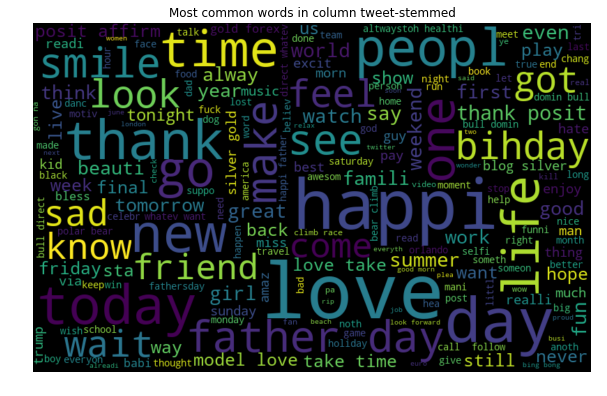

In [202]:
# visualizing all the words in column "tweet_stemmed" in our data using the wordcloud plot.
all_words = ' '.join([text for text in combine_tweets['tweet_stemmed']])
word_cloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in column tweet-stemmed')
plt.show()

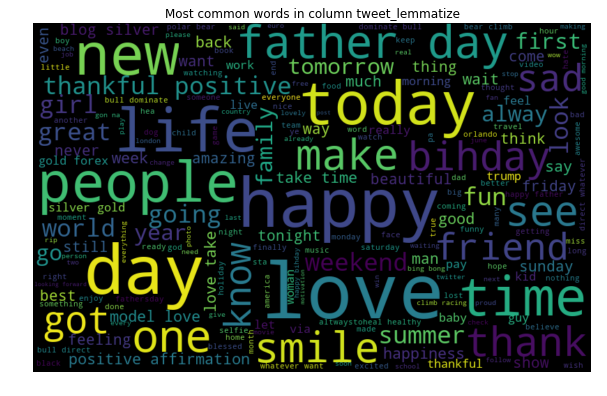

In [203]:
# visualizing all the words in column "tweet_lemmatized" in our data using the wordcloud plot.
all_words = ' '.join([text for text in combine_tweets['tweet_lemmatize']])
word_cloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in column tweet_lemmatize')
plt.show()

# B) Most common words in non racist/sexist tweets

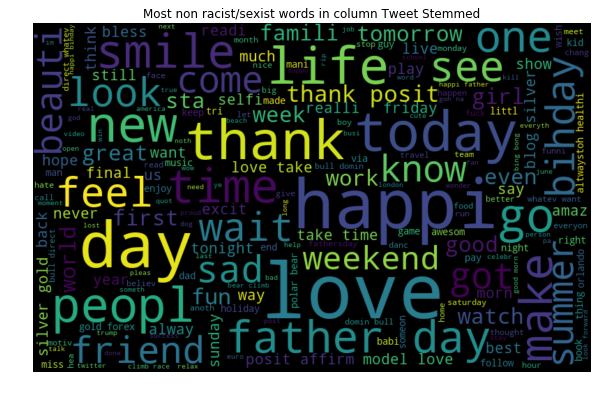

In [204]:
#Visualizing all the normal or non racist/sexist words in column "tweet_stemmed" in our data using the wordcloud plot.
normal_words = ' '.join([text for text in combine_tweets['tweet_stemmed'][combine_tweets['label']==0]])
word_cloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most non racist/sexist words in column Tweet Stemmed')
plt.show()

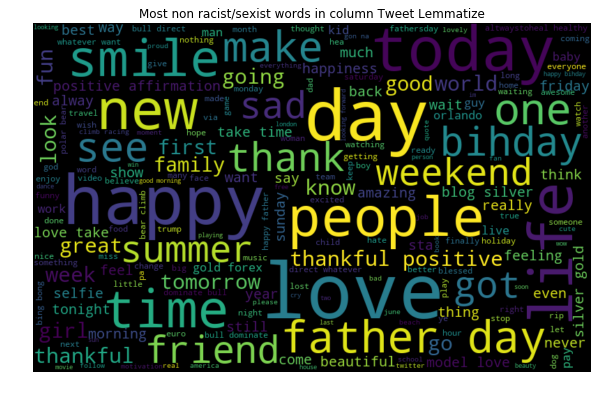

In [205]:
#Visualizing all the normal or non racist/sexist words in column "tweet_stemmed" in our data using the wordcloud plot.
normal_words = ' '.join([text for text in combine_tweets['tweet_lemmatize'][combine_tweets['label']==0]])
word_cloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most non racist/sexist words in column Tweet Lemmatize')
plt.show()

# C. Most common words  in racist/sexist tweet

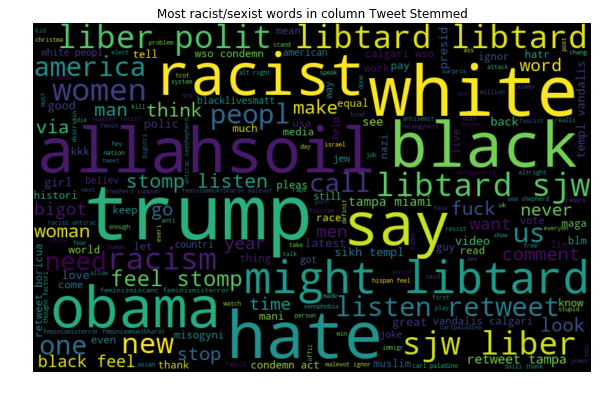

In [206]:
#Visualizing all the negative or racist/sexist words in column "tweet_stemmed" in our data using the wordcloud plot.
negetive_words = ' '.join([text for text in combine_tweets['tweet_stemmed'][combine_tweets['label']==1]])
word_cloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negetive_words)
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most racist/sexist words in column Tweet Stemmed')
plt.show()

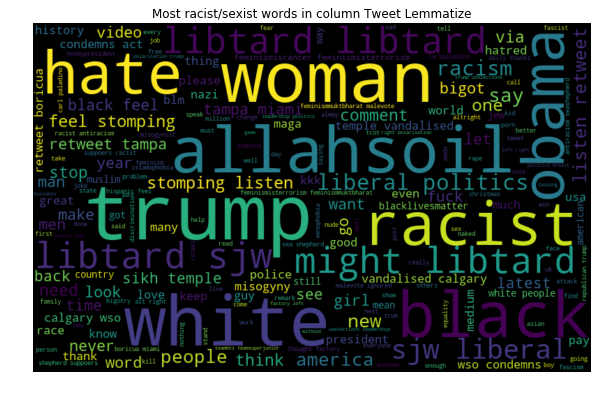

In [207]:
#Visualizing all the negative or racist/sexist words in column "tweet_lemmatize" in our data using the wordcloud plot.
negetive_words = ' '.join([text for text in combine_tweets['tweet_lemmatize'][combine_tweets['label']==1]])
word_cloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negetive_words)
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most racist/sexist words in column Tweet Lemmatize')
plt.show()

In above plots we can see most of the words are negative or racist/sexist. With racist, hate and black being the most frequent ones.

# Extracting Features from Cleaned Tweets

A - Bag-of-Words Features

In [214]:
# bag-of-words features matrix for column tweet_stemmed and tweet_lemmatize
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=1000, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [216]:
# bag-of-words feature matrix - For columns "combine_df['tweet_stemmed']"
bow_stem = bow_vectorizer.fit_transform(combine_tweets['tweet_stemmed'])
bow_stem

<49159x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 203386 stored elements in Compressed Sparse Row format>

In [222]:
bow_stem.shape

(49159, 1000)

In [219]:
# bag-of-words feature matrix - For column - combine_df['tweet_lemmatized']
bow_lemm = bow_vectorizer.fit_transform(combine_tweets['tweet_lemmatize'])
bow_lemm

<49159x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 187343 stored elements in Compressed Sparse Row format>

In [223]:
bow_lemm.shape

(49159, 1000)

# Logistic Regression Model Building: Twitter Sentiment Analysis

Building model using Bag-of-Words features

In [257]:
# building model on stem column
def stem_model(bow_stem):
    
    # For columns tweet_stemmed
    train_bow_stem = bow_stem[:31962,:]
    test_bow_stem = bow_stem[31962:,:]

    # saving test data  in pickle file for testing purpose     
    test_pickle = open('Test_data/stem_test.pickle','wb')
    pickle.dump(test_bow_stem,test_pickle)
    test_pickle.close()
    
    # splitting data into training and validation set
    xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow_stem, train_tweet['label'],random_state=42, test_size=0.3)

    lreg = LogisticRegression()
    
     # training the model
    classify = lreg.fit(xtrain_bow, ytrain)
    # predicting on the validation set
    prediction = lreg.predict_proba(xvalid_bow) 
    # if prediction is greater than or equal to 0.3 than 1 else 0
    prediction_int = prediction[:,1] >= 0.3 
    prediction_int = prediction_int.astype(np.int)
    # calculating f1 score on validation data
    score = f1_score(yvalid, prediction_int) 
    
    # save our  trained model
    model = open('Pickle/StemModel.pickle','wb')
    pickle.dump(classify, model)
    pickle.dump(bow_stem,model)
    model.close()
    
    return score
    
score_stem = stem_model(bow_stem)
print("Stemming gives {}% score".format(score_stem*100))


Stemming gives 55.509527754763866% score


/home/admin1/Downloads/Enter/envs/my_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [256]:
# building model on stem column
def lemma_model(bow_lemm):
    
    # For columns tweet_stemmed
    train_bow_lemma = bow_lemm[:31962,:]
    test_bow_lemma = bow_lemm[31962:,:]

    # saving test data  in pickle file for testing purpose     
    test_pickle = open('Test_data/lemma_test.pickle','wb')
    pickle.dump(test_bow_lemma,test_pickle)
    test_pickle.close()
    
    # splitting data into training and validation set
    xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow_lemma, train_tweet['label'],random_state=42, test_size=0.3)

    lreg = LogisticRegression()
    
     # training the model
    classify = lreg.fit(xtrain_bow, ytrain)
    # predicting on the validation set
    prediction = lreg.predict_proba(xvalid_bow) 
    # if prediction is greater than or equal to 0.3 than 1 else 0
    prediction_int = prediction[:,1] >= 0.3 
    prediction_int = prediction_int.astype(np.int)
    # calculating f1 score on validation data
    score = f1_score(yvalid, prediction_int) 
     # save our  trained model
    model = open('Pickle/LemmaModel.pickle','wb')
    pickle.dump(classify, model)
    model.close()
    
    return score
# lemma  function  called 
score_lemma = lemma_model(bow_lemm)
print("Lemma gives {}% score".format(score_lemma*100))

Lemma gives 53.72112917023097% score


In [250]:
print("F1 - Score Chart")
print("* F1-Score - Model using Bag-of-Words features")
print("     F1-Score = ",score_stem*100," - For column tweets are stemmed")
print("     F1-Score = ",score_lemma*100," - For column tweets are Lemmatized")

F1 - Score Chart
* F1-Score - Model using Bag-of-Words features
     F1-Score =  55.509527754763866  - For column tweets are stemmed
     F1-Score =  53.72112917023097  - For column tweets are Lemmatized
